# Step 1: Exploring Data

The purpose of this notebook is to do some preliminary basic data exploration. The goal is to better understand the data. This notebook attemps to answer questions such as how many unique models, how many unique vendors, missing data, correlation of the covariates and label, any intersting patterns in the SMART stats over time, etc.

In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

from matplotlib import pyplot as plt
import seaborn as sns

import pdb

In [2]:
# inferred int64 types cause a type mismatch (int vs float) error when dask sees a null value
# null values cannot be interpreted as ints
custom_dtypes = {
    "date": "object",
    "serial_number": "object",
    "model": "object",
    "capacity_bytes": "float64",
    "failure": "float64",
    "smart_1_normalized": "float64",
    "smart_1_raw": "float64",
    "smart_2_normalized": "float64",
    "smart_2_raw": "float64",
    "smart_3_normalized": "float64",
    "smart_3_raw": "float64",
    "smart_4_normalized": "float64",
    "smart_4_raw": "float64",
    "smart_5_normalized": "float64",
    "smart_5_raw": "float64",
    "smart_7_normalized": "float64",
    "smart_7_raw": "float64",
    "smart_8_normalized": "float64",
    "smart_8_raw": "float64",
    "smart_9_normalized": "float64",
    "smart_9_raw": "float64",
    "smart_10_normalized": "float64",
    "smart_10_raw": "float64",
    "smart_11_normalized": "float64",
    "smart_11_raw": "float64",
    "smart_12_normalized": "float64",
    "smart_12_raw": "float64",
    "smart_13_normalized": "float64",
    "smart_13_raw": "float64",
    "smart_15_normalized": "float64",
    "smart_15_raw": "float64",
    "smart_16_normalized": "float64",
    "smart_16_raw": "float64",
    "smart_17_normalized": "float64",
    "smart_17_raw": "float64",
    "smart_22_normalized": "float64",
    "smart_22_raw": "float64",
    "smart_23_normalized": "float64",
    "smart_23_raw": "float64",
    "smart_24_normalized": "float64",
    "smart_24_raw": "float64",
    "smart_168_normalized": "float64",
    "smart_168_raw": "float64",
    "smart_170_normalized": "float64",
    "smart_170_raw": "float64",
    "smart_173_normalized": "float64",
    "smart_173_raw": "float64",
    "smart_174_normalized": "float64",
    "smart_174_raw": "float64",
    "smart_177_normalized": "float64",
    "smart_177_raw": "float64",
    "smart_179_normalized": "float64",
    "smart_179_raw": "float64",
    "smart_181_normalized": "float64",
    "smart_181_raw": "float64",
    "smart_182_normalized": "float64",
    "smart_182_raw": "float64",
    "smart_183_normalized": "float64",
    "smart_183_raw": "float64",
    "smart_184_normalized": "float64",
    "smart_184_raw": "float64",
    "smart_187_normalized": "float64",
    "smart_187_raw": "float64",
    "smart_188_normalized": "float64",
    "smart_188_raw": "float64",
    "smart_189_normalized": "float64",
    "smart_189_raw": "float64",
    "smart_190_normalized": "float64",
    "smart_190_raw": "float64",
    "smart_191_normalized": "float64",
    "smart_191_raw": "float64",
    "smart_192_normalized": "float64",
    "smart_192_raw": "float64",
    "smart_193_normalized": "float64",
    "smart_193_raw": "float64",
    "smart_194_normalized": "float64",
    "smart_194_raw": "float64",
    "smart_195_normalized": "float64",
    "smart_195_raw": "float64",
    "smart_196_normalized": "float64",
    "smart_196_raw": "float64",
    "smart_197_normalized": "float64",
    "smart_197_raw": "float64",
    "smart_198_normalized": "float64",
    "smart_198_raw": "float64",
    "smart_199_normalized": "float64",
    "smart_199_raw": "float64",
    "smart_200_normalized": "float64",
    "smart_200_raw": "float64",
    "smart_201_normalized": "float64",
    "smart_201_raw": "float64",
    "smart_218_normalized": "float64",
    "smart_218_raw": "float64",
    "smart_220_normalized": "float64",
    "smart_220_raw": "float64",
    "smart_222_normalized": "float64",
    "smart_222_raw": "float64",
    "smart_223_normalized": "float64",
    "smart_223_raw": "float64",
    "smart_224_normalized": "float64",
    "smart_224_raw": "float64",
    "smart_225_normalized": "float64",
    "smart_225_raw": "float64",
    "smart_226_normalized": "float64",
    "smart_226_raw": "float64",
    "smart_231_normalized": "float64",
    "smart_231_raw": "float64",
    "smart_232_normalized": "float64",
    "smart_232_raw": "float64",
    "smart_233_normalized": "float64",
    "smart_233_raw": "float64",
    "smart_235_normalized": "float64",
    "smart_235_raw": "float64",
    "smart_240_normalized": "float64",
    "smart_240_raw": "float64",
    "smart_241_normalized": "float64",
    "smart_241_raw": "float64",
    "smart_242_normalized": "float64",
    "smart_242_raw": "float64",
    "smart_250_normalized": "float64",
    "smart_250_raw": "float64",
    "smart_251_normalized": "float64",
    "smart_251_raw": "float64",
    "smart_252_normalized": "float64",
    "smart_252_raw": "float64",
    "smart_254_normalized": "float64",
    "smart_254_raw": "float64",
    "smart_255_normalized": "float64",
    "smart_255_raw": "float64",
}

In [3]:
# read all the data into one dataframe
# NOTE: assumes aws credentials are stored as env vars or in ~/.aws/credentials
# TODO: move to reading from Ceph after slow read blocker is removed
df = dd.read_csv("/home/kachauha/Downloads/data_Q4_2018/*.csv", dtype=custom_dtypes)
# df = dd.read_csv(
#     "s3://DH-PLAYPEN/kachauha/*/*.csv",
#     storage_options={
#         "client_kwargs": {"endpoint_url": "https://s3.upshift.redhat.com/"}
#     },
#     dtype=custom_dtypes
# )

## Summaries

In [4]:
# get the serial numbers for all the failed hard drives, date of failure, and its model
failed_serials = df[df['failure']==1][['date', 'serial_number', 'model']].compute()
# print(failed_serials.shape)    # (393, 3)
failed_serials.head()

,date,serial_number,model
24449,2018-10-01,S2ZYJ9CFC01460,ST500LM012 HN
29978,2018-10-01,Z305B8DE,ST4000DM000
38504,2018-10-01,ZA10CTP4,ST8000DM002
38544,2018-10-01,ZA114N2J,ST8000DM002
40880,2018-10-01,ZCH0CLFQ,ST12000NM0007


In [5]:
failed_serials.tail()

,date,serial_number,model
47582,2018-12-30,PL2331LAGSUD2J,HGST HMS5C4040ALE640
63756,2018-12-30,Z3025L0M,ST4000DM000
21700,2018-12-31,ZCH07CVK,ST12000NM0007
35745,2018-12-31,ZCH09GNA,ST12000NM0007
89121,2018-12-31,ZCH0841G,ST12000NM0007


In [6]:
# get the serial numbers for all the failed hard drives, date of failure, and its model
# multiple entries will exist per serial number since it will be a time series. get only the last one
working_serials = df[~df['serial_number'].isin(failed_serials['serial_number'])][['date', 'serial_number', 'model']]\
                    .drop_duplicates(subset='serial_number', keep='last')\
                    .compute()
# print(working_serials.shape)    # (108325, 3)
working_serials.head()

,date,serial_number,model
2203,2018-10-02,Z300XGTR,ST4000DM000
4389,2018-10-02,Z300XA99,ST4000DM000
4900,2018-10-02,Z3015BTR,ST4000DM000
6971,2018-10-02,Z300WWNK,ST4000DM000
7928,2018-10-02,PL2331LAGSSUNJ,HGST HMS5C4040ALE640


In [7]:
working_serials.tail()

,date,serial_number,model
106911,2018-12-31,PL1331LAHD1AWH,HGST HMS5C4040BLE640
106912,2018-12-31,ZA10MCEQ,ST8000DM002
106913,2018-12-31,PL1331LAHD0AHH,HGST HMS5C4040BLE640
106914,2018-12-31,PL1331LAHD1T5H,HGST HMS5C4040BLE640
106915,2018-12-31,Z30271GD,ST4000DM000


In [8]:
# sanity check - make sure we havent labelled a serial number as BOTH working and failed
working_serials['serial_number'].isin(failed_serials['serial_number']).any()

False

In [8]:
# are there any specific models that failed more so than the others?
model_stats = pd.merge(failed_serials['model'].value_counts().to_frame('failed_count').reset_index(),
                        working_serials['model'].value_counts().to_frame('working_count').reset_index(),
                        how='outer').fillna(0)

# rename the index column as the model column
model_stats.rename(columns={'index': 'model'}, inplace=True)

# # sanity check - did the merge include all the observations or did it drop any?
# (foo['index'].isin(tmp['index'])).all() and (bar['index'].isin(tmp['index']).all())    # True

# percentage of instances that have failed, per model
model_stats['fail_percent'] = 100 * model_stats['failed_count'] / (model_stats['failed_count'] + model_stats['working_count'])
model_stats

,model,failed_count,working_count,fail_percent
0,ST12000NM0007,130.0,31144,0.415681
1,ST4000DM000,121.0,24274,0.496003
2,ST8000NM0055,39.0,14384,0.270401
3,ST8000DM002,24.0,9874,0.242473
4,HGST HMS5C4040BLE640,18.0,14649,0.122724
5,ST500LM012 HN,13.0,613,2.076677
6,TOSHIBA MQ01ABF050,12.0,528,2.222222
7,TOSHIBA MG07ACA14TA,7.0,1220,0.570497
8,HGST HMS5C4040ALE640,7.0,4836,0.144539
9,ST500LM030,7.0,111,5.932203


**NOTE** Although there are 48 different models of hard drives being used, these are coming from only 5 unique vendors. The values of SMART stats and whether or not they are reported varies from vendor to vendor. Furthermore, simply including vendor as a feature may or may not work for all kinds of prediction models. Therefore, it may be a good idea to analyze the data in a vendor specific way.

In [9]:
# split data into the 5 vendors - seagate, wdc, hgst, hitachi, toshiba
wdc_df = df[df['model'].str.startswith('W')]
hgst_df = df[df['model'].str.startswith('HG')]
toshiba_df = df[df['model'].str.startswith('T')]
seagate_df = df[df['model'].str.startswith('S')]
hitachi_df = df[df['model'].str.startswith('Hi')]

In [10]:
# how many from each vendor do we have
print(dd.compute(wdc_df.shape[0]))
print(dd.compute(hgst_df.shape[0]))
print(dd.compute(toshiba_df.shape[0]))
print(dd.compute(seagate_df.shape[0]))
print(dd.compute(hitachi_df.shape[0]))

(68637,)
(1929277,)
(206129,)
(7152178,)
(1388,)


In [11]:
def get_vendor(model_name):
    """Returns the vendor/manufacturer name for a given hard drive model name
    
    Arguments:
        model_name {str} -- model name of the hard drive
    
    Returns:
        str -- vendor name
    """
    if model_name.startswith('W'):
        return 'WDC'
    elif model_name.startswith('T'):
        return 'Toshiba'
    elif model_name.startswith('S'):
        return 'Seagate'
    elif model_name.startswith('Hi'):
        return 'Hitachi'
    else:
        return 'HGST'

In [12]:
# model_stats[model_stats['model'].str.startswith('S')]['vendor'] = 'Seagate'    
model_stats['vendor'] = model_stats['model'].apply(get_vendor)
model_stats.head()

,model,failed_count,working_count,fail_percent,vendor
0,ST12000NM0007,130.0,31144,0.415681,Seagate
1,ST4000DM000,121.0,24274,0.496003,Seagate
2,ST8000NM0055,39.0,14384,0.270401,Seagate
3,ST8000DM002,24.0,9874,0.242473,Seagate
4,HGST HMS5C4040BLE640,18.0,14649,0.122724,HGST


In [13]:
# get vendor-wise stats for failed vs working
vendor_stats = model_stats.groupby('vendor').sum()
vendor_stats['fail_percent'] = 100 * vendor_stats['failed_count'] / (vendor_stats['failed_count'] + vendor_stats['working_count'])
vendor_stats

,failed_count,working_count,fail_percent
vendor,,,
HGST,26.0,21901,0.118575
Hitachi,0.0,16,0.000000
Seagate,341.0,83287,0.407758
Toshiba,21.0,2322,0.896287
WDC,5.0,799,0.621891


In [14]:
# TODO: should we create a corr matrix for model vs failure or would it lead to misinterpretation of information

## Analyze Critical Stats

These are the columns specified by wikipedia, backblaze, and IBM research as good predictors.

1. Backblaze mentions five stats as better predictors than others. These are 5, 187, 188, 197, 198.They also provide some [analysis](https://www.backblaze.com/blog/what-smart-stats-indicate-hard-drive-failures/) using these features.

2. IBM published a [paper](https://www.kdd.org/kdd2016/papers/files/adf0849-botezatuA.pdf) regarding drive failure prediction as well.

3. Wikipedia also [mentions](https://en.wikipedia.org/wiki/S.M.A.R.T.#ATA_S.M.A.R.T._attributes) some predictors as critical.

In [4]:
CRITICAL_STATS = [1, 5, 7, 10, 184, 187, 188, 189, 190, 193, 194, 196, 197, 198, 201, 240, 241, 242]

# NOTE - THESE LISTS ARE SUBJECT TO CHANGE
crit_cols_raw = ['smart_{}_raw'.format(i) for i in CRITICAL_STATS]
crit_cols_normalized = ['smart_{}_normalized'.format(i) for i in CRITICAL_STATS]

### SMART Stats Descriptions
Source: Wikipedia

Putting descriptions here to help better make sense of the results that follow.

184 = end to end error / ioedc : This attribute is a part of Hewlett-Packard's SMART IV technology, as well as part of other vendors' IO Error Detection and Correction schemas, and it contains a count of parity errors which occur in the data path to the media via the drive's cache RAM.

187 = reported uncorrectable errors : The count of errors that could not be recovered using hardware ECC (see attribute 195)

188 = command timeout : The count of aborted operations due to HDD timeout. Normally this attribute value should be equal to zero.

189 = high fly write : This feature is implemented in most modern Seagate drives and some of Western Digital's drives, beginning with the WD Enterprise WDE18300 and WDE9180 Ultra2 SCSI hard drives, and will be included on all future WD Enterprise products.

190 = temp diff / airflow diff : Value is equal to (100-temp. °C), allowing manufacturer to set a minimum threshold which corresponds to a maximum temperature. This also follows the convention of 100 being a best-case value and lower values being undesirable. However, some older drives may instead report raw Temperature (identical to 0xC2) or Temperature minus 50 here.

196 = reallocation event count : Count of remap operations. The raw value of this attribute shows the total count of attempts to transfer data from reallocated sectors to a spare area. Both successful and unsuccessful attempts are counted

201 = soft read eror rate or TA counter detected : Count indicates the number of uncorrectable software read errors.

### NaN Counts

In [5]:
# number of nans
print('All data')
nan_count = df[crit_cols_raw + crit_cols_normalized].isna().sum().to_frame('count')
nan_count['percent'] = 100 * nan_count['count'] / dd.compute(df.shape[0])
nan_count = nan_count.compute()
nan_count

All data


,count,percent
smart_1_raw,363,0.003879
smart_5_raw,863,0.009222
smart_7_raw,863,0.009222
smart_10_raw,863,0.009222
smart_184_raw,4721683,50.458221
smart_187_raw,2261196,24.164250
smart_188_raw,2261196,24.164250
smart_189_raw,4721683,50.458221
smart_190_raw,2261196,24.164250
smart_193_raw,56221,0.600805


Some vendors may not provide certain SMART stats. This could be one possible explanation for the high number of nans. If this is the case, then that particular feature will not be helpful for predicting status of a drive from that vendor. Lets get the vendor-wise nans

In [17]:
print('Seagate')
seagate_nan_ct = seagate_df[crit_cols_raw + crit_cols_normalized].isna().sum().to_frame('count')
seagate_nan_ct['percent'] = 100 * seagate_nan_ct['count'] / dd.compute(seagate_df.shape[0])
seagate_nan_ct = seagate_nan_ct.compute()
seagate_nan_ct

Seagate


,count,percent
smart_1_raw,306,0.004278
smart_5_raw,806,0.011269
smart_7_raw,806,0.011269
smart_10_raw,806,0.011269
smart_184_raw,2516252,35.181619
smart_187_raw,55765,0.779693
smart_188_raw,55765,0.779693
smart_189_raw,2516252,35.181619
smart_190_raw,55765,0.779693
smart_193_raw,56164,0.785271


In [18]:
print('WDC')
wdc_nan_ct = wdc_df[crit_cols_raw + crit_cols_normalized].isna().sum().to_frame('count')
wdc_nan_ct['percent'] = 100 * wdc_nan_ct['count'] / dd.compute(wdc_df.shape[0])
wdc_nan_ct = wdc_nan_ct.compute()
wdc_nan_ct

WDC


,count,percent
smart_1_raw,0,0.000000
smart_5_raw,0,0.000000
smart_7_raw,0,0.000000
smart_10_raw,0,0.000000
smart_184_raw,68637,100.000000
smart_187_raw,68637,100.000000
smart_188_raw,68637,100.000000
smart_189_raw,68637,100.000000
smart_190_raw,68637,100.000000
smart_193_raw,0,0.000000


In [19]:
print('HGST')
hgst_nan_ct = hgst_df[crit_cols_raw + crit_cols_normalized].isna().sum().to_frame('count')
hgst_nan_ct['percent'] = 100 * hgst_nan_ct['count'] / dd.compute(hgst_df.shape[0])
hgst_nan_ct = hgst_nan_ct.compute()
hgst_nan_ct

HGST


,count,percent
smart_1_raw,52,0.002695
smart_5_raw,52,0.002695
smart_7_raw,52,0.002695
smart_10_raw,52,0.002695
smart_184_raw,1929277,100.000000
smart_187_raw,1929277,100.000000
smart_188_raw,1929277,100.000000
smart_189_raw,1929277,100.000000
smart_190_raw,1929277,100.000000
smart_193_raw,52,0.002695


In [20]:
print('Hitachi')
hitachi_nan_ct = hitachi_df[crit_cols_raw + crit_cols_normalized].isna().sum().to_frame('count')
hitachi_nan_ct['percent'] = 100 * hitachi_nan_ct['count'] / dd.compute(hitachi_df.shape[0])
hitachi_nan_ct = hitachi_nan_ct.compute()
hitachi_nan_ct

Hitachi


,count,percent
smart_1_raw,0,0.0
smart_5_raw,0,0.0
smart_7_raw,0,0.0
smart_10_raw,0,0.0
smart_184_raw,1388,100.0
smart_187_raw,1388,100.0
smart_188_raw,1388,100.0
smart_189_raw,1388,100.0
smart_190_raw,1388,100.0
smart_193_raw,0,0.0


In [21]:
print('Toshiba')
toshiba_nan_ct = toshiba_df[crit_cols_raw + crit_cols_normalized].isna().sum().to_frame('count')
toshiba_nan_ct['percent'] = 100 * toshiba_nan_ct['count'] / dd.compute(toshiba_df.shape[0])
toshiba_nan_ct = toshiba_nan_ct.compute()
toshiba_nan_ct

Toshiba


,count,percent
smart_1_raw,5,0.002426
smart_5_raw,5,0.002426
smart_7_raw,5,0.002426
smart_10_raw,5,0.002426
smart_184_raw,206129,100.000000
smart_187_raw,206129,100.000000
smart_188_raw,206129,100.000000
smart_189_raw,206129,100.000000
smart_190_raw,206129,100.000000
smart_193_raw,5,0.002426


### TODO: are the nans meaningless or do they imply 0?

In [22]:
# general description
# NOTE: the columns with all values NAN must be removed otherwise a value error is thrown
summary = df[nan_count.index[nan_count['percent'] != 100]].describe().compute()
summary

,smart_1_raw,smart_5_raw,smart_7_raw,smart_10_raw,smart_184_raw,smart_187_raw,smart_188_raw,smart_189_raw,smart_190_raw,smart_193_raw,...,smart_189_normalized,smart_190_normalized,smart_193_normalized,smart_194_normalized,smart_196_normalized,smart_197_normalized,smart_198_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized
count,9.357246e+06,9.356746e+06,9.356746e+06,9.356746e+06,4.635926e+06,7.096413e+06,7.096413e+06,4.635926e+06,7.096413e+06,9.301388e+06,...,4.635926e+06,7.096413e+06,9.301388e+06,9.357246e+06,2.260333e+06,9.356746e+06,9.356746e+06,7.309569e+06,7.097659e+06,7.097659e+06
mean,9.261374e+07,5.758754e+00,1.668407e+09,2.204315e+01,3.828146e-03,7.047532e-02,8.081638e+07,6.583353e+00,2.917716e+01,1.529214e+04,...,9.905657e+01,7.082284e+01,9.394564e+01,6.880345e+01,1.067165e+02,1.016213e+02,1.009117e+02,9.996057e+01,1.000128e+02,1.000128e+02
std,8.062069e+07,3.179134e+02,4.613208e+10,1.696482e+03,3.651873e-01,2.097952e+00,3.313243e+09,5.047425e+02,6.324315e+00,4.376572e+04,...,5.412752e+00,6.324315e+00,1.778591e+01,7.406983e+01,2.865193e+01,1.434108e+01,1.169487e+01,1.312996e+00,1.132854e+00,1.132854e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.400000e+01,1.000000e+00,...,1.000000e+00,4.400000e+01,1.000000e+00,1.400000e+01,1.200000e+01,3.900000e+01,3.900000e+01,3.200000e+01,1.000000e+02,1.000000e+02
25%,5.642790e+06,0.000000e+00,3.757985e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.600000e+01,3.850000e+02,...,1.000000e+02,6.700000e+01,9.800000e+01,2.900000e+01,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
50%,8.624679e+07,0.000000e+00,4.826357e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.100000e+01,3.049000e+03,...,1.000000e+02,7.300000e+01,1.000000e+02,3.700000e+01,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
75%,1.688201e+08,0.000000e+00,1.268629e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.600000e+01,1.404325e+04,...,1.000000e+02,7.700000e+01,1.000000e+02,1.870000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
max,8.449025e+08,5.532000e+04,1.064935e+13,3.276800e+05,7.200000e+01,5.240000e+02,6.013057e+11,6.553500e+04,5.600000e+01,1.104852e+06,...,1.000000e+02,8.600000e+01,2.000000e+02,2.530000e+02,2.520000e+02,2.520000e+02,2.520000e+02,1.000000e+02,2.000000e+02,2.000000e+02


363 out of 9357609 are NaN values. These are not shown on the graph


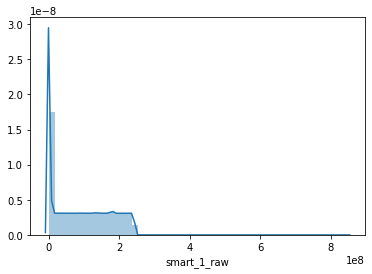

863 out of 9357609 are NaN values. These are not shown on the graph


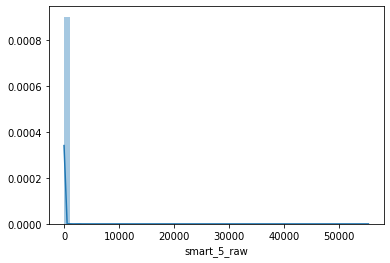

863 out of 9357609 are NaN values. These are not shown on the graph


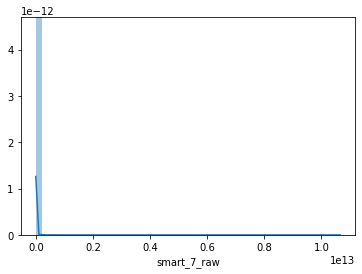

863 out of 9357609 are NaN values. These are not shown on the graph


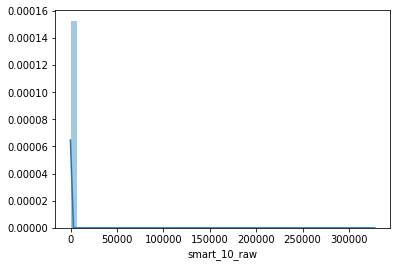

4721683 out of 9357609 are NaN values. These are not shown on the graph


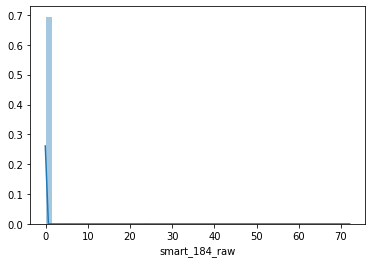

2261196 out of 9357609 are NaN values. These are not shown on the graph


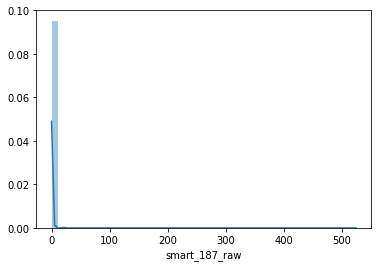

2261196 out of 9357609 are NaN values. These are not shown on the graph


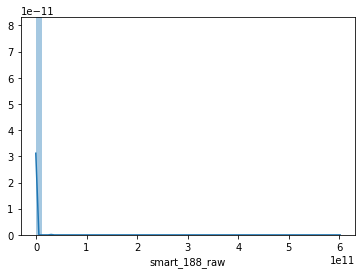

4721683 out of 9357609 are NaN values. These are not shown on the graph


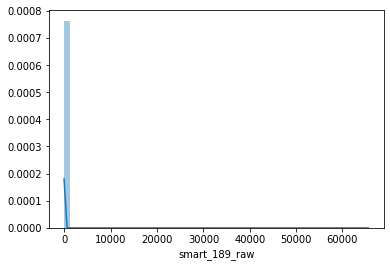

2261196 out of 9357609 are NaN values. These are not shown on the graph


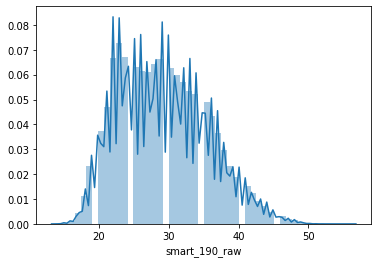

56221 out of 9357609 are NaN values. These are not shown on the graph


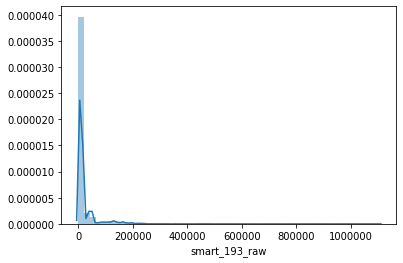

363 out of 9357609 are NaN values. These are not shown on the graph


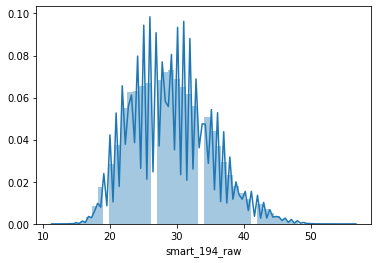

7097276 out of 9357609 are NaN values. These are not shown on the graph


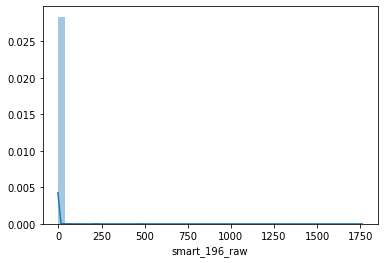

863 out of 9357609 are NaN values. These are not shown on the graph


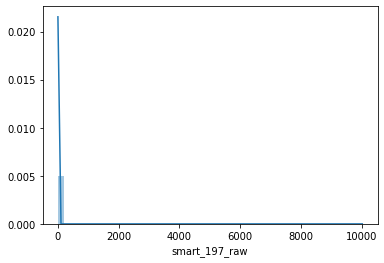

863 out of 9357609 are NaN values. These are not shown on the graph


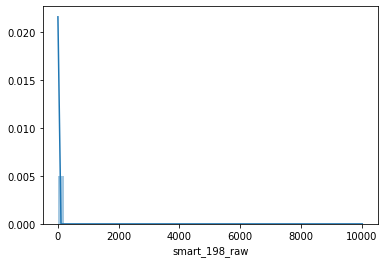

2048040 out of 9357609 are NaN values. These are not shown on the graph


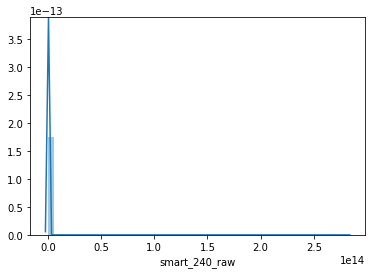

2259950 out of 9357609 are NaN values. These are not shown on the graph


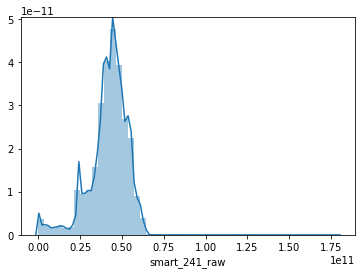

2259950 out of 9357609 are NaN values. These are not shown on the graph


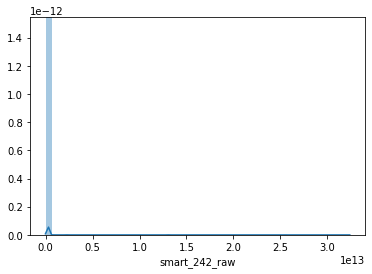

363 out of 9357609 are NaN values. These are not shown on the graph


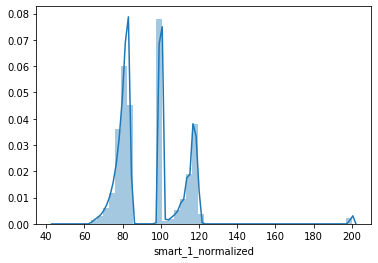

863 out of 9357609 are NaN values. These are not shown on the graph


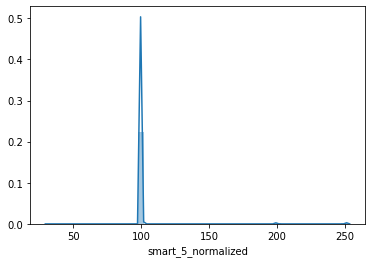

863 out of 9357609 are NaN values. These are not shown on the graph


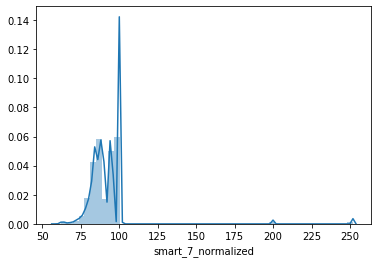

863 out of 9357609 are NaN values. These are not shown on the graph


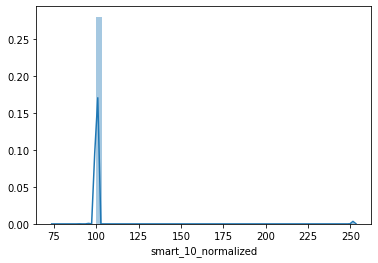

4721683 out of 9357609 are NaN values. These are not shown on the graph


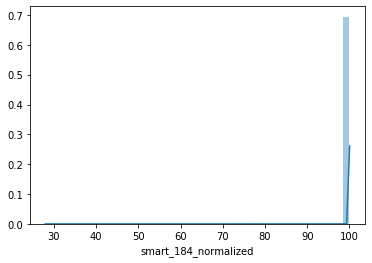

2261196 out of 9357609 are NaN values. These are not shown on the graph


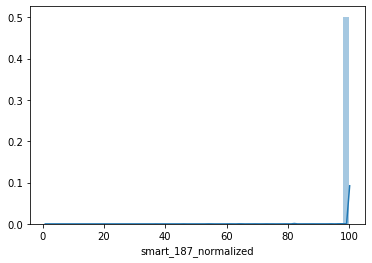

2261196 out of 9357609 are NaN values. These are not shown on the graph


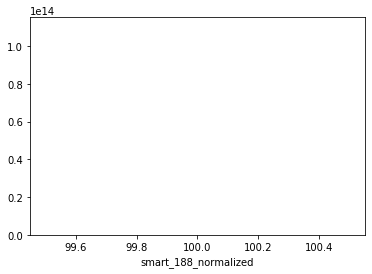

4721683 out of 9357609 are NaN values. These are not shown on the graph


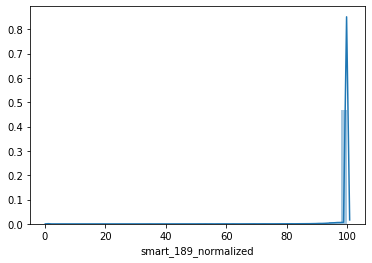

2261196 out of 9357609 are NaN values. These are not shown on the graph


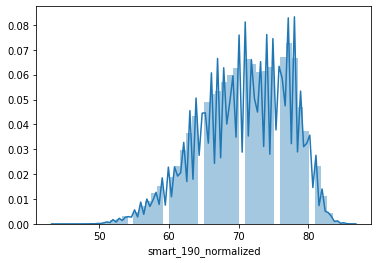

56221 out of 9357609 are NaN values. These are not shown on the graph


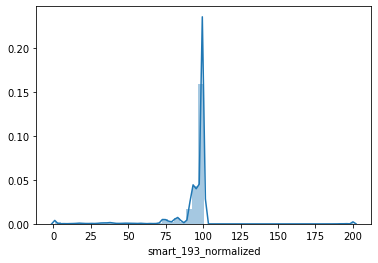

363 out of 9357609 are NaN values. These are not shown on the graph


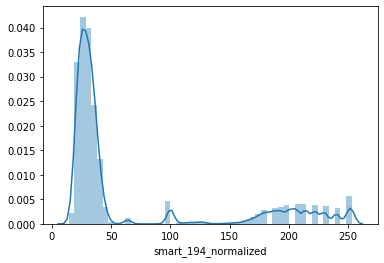

7097276 out of 9357609 are NaN values. These are not shown on the graph


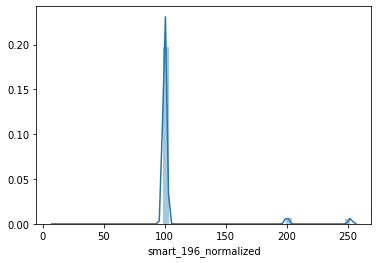

863 out of 9357609 are NaN values. These are not shown on the graph


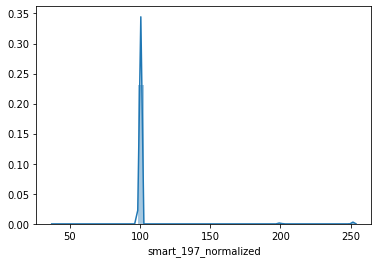

863 out of 9357609 are NaN values. These are not shown on the graph


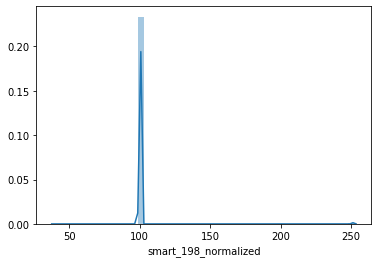

2048040 out of 9357609 are NaN values. These are not shown on the graph


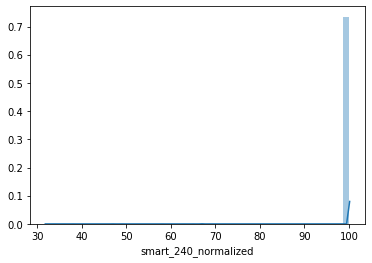

2259950 out of 9357609 are NaN values. These are not shown on the graph


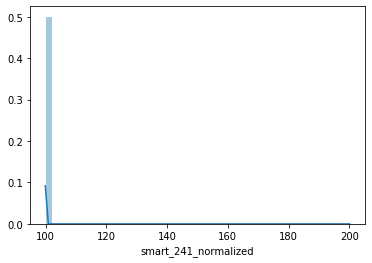

2259950 out of 9357609 are NaN values. These are not shown on the graph


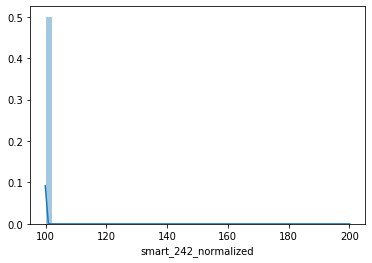

In [7]:
# plot histograms for overall data
# it would probably be more insightful to do this per vendor, but start with overall
# dont make the hist if all values are nan
hist_cols = nan_count.index[nan_count['percent'] != 100]    # + ['failure', 'capacity_bytes']
for col in hist_cols:
    # get all the values for this column
    data = df[col].compute()

    # plot only the non null values
    print(data.isna().sum(), 'out of', data.shape[0], 'are NaN values. These are not shown on the graph below')
    sns.distplot(data[~data.isna()])
    plt.show()

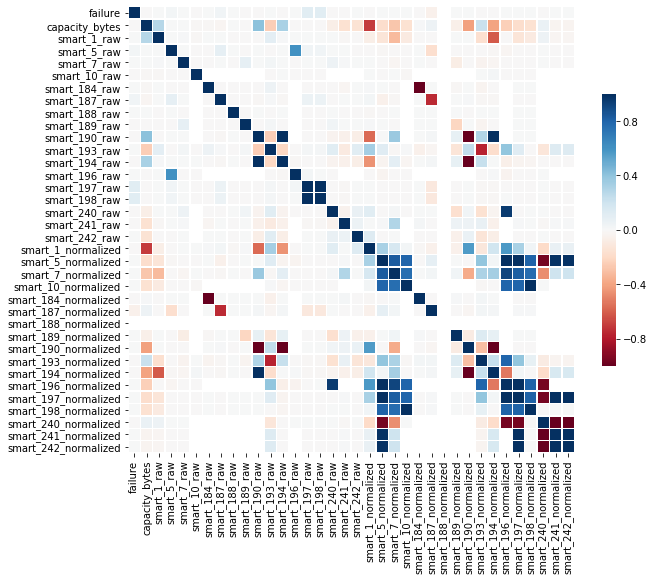

In [102]:
# correlation with failure
# corr_cols = ['failure', 'capacity_bytes'] + crit_cols_raw + crit_cols_normalized
corr_cols = ['failure', 'capacity_bytes'] + list(nan_count.index[nan_count['percent'] != 100])
corr_mat = df[corr_cols].corr().compute()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_mat,
            ax=ax,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=.5,
            cmap='RdBu',
            cbar_kws={"shrink": .5})

In [111]:
# only those attributes with less than NAN_PERCENT_THRESHOLD% values as NaN's
# will be selected for computing the correaltion matirx
NAN_PERCENT_THRESHOLD = 100

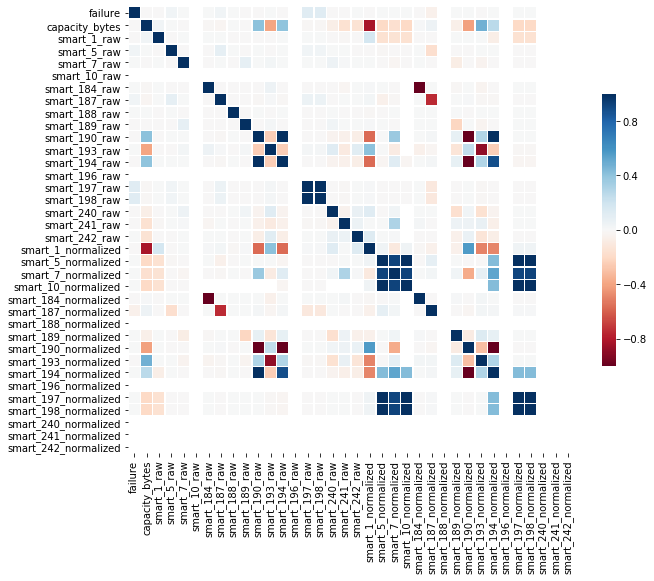

In [128]:
# correlation matrix for seagaet drives
seagate_corr_cols = ['failure', 'capacity_bytes']  + list(seagate_nan_ct.index[seagate_nan_ct['percent'] < NAN_PERCENT_THRESHOLD])
seagate_corr = seagate_df[seagate_corr_cols].corr().compute()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(seagate_corr,
            ax=ax,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=.5,
            cmap='RdBu',
            cbar_kws={"shrink": .5})

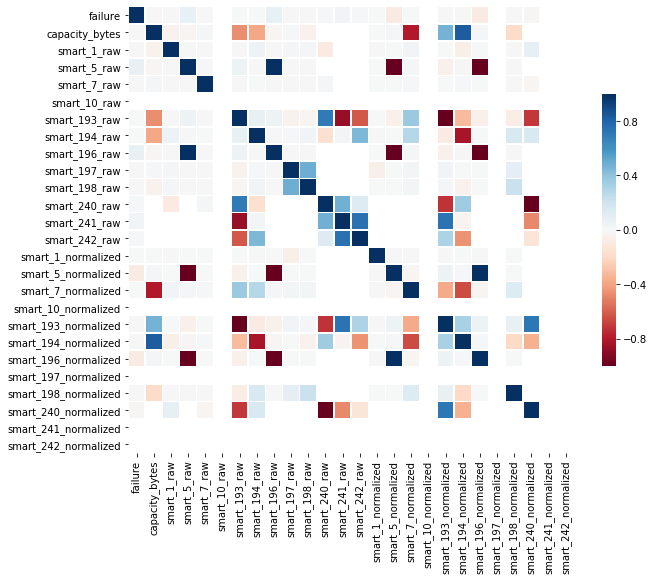

In [129]:
# correlation matrix for wdc drives
wdc_corr_cols = ['failure', 'capacity_bytes'] + list(wdc_nan_ct.index[wdc_nan_ct['percent'] < NAN_PERCENT_THRESHOLD])
wdc_corr = wdc_df[wdc_corr_cols].corr().compute()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(wdc_corr,
            ax=ax,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=.5,
            cmap='RdBu',
            cbar_kws={"shrink": .5})

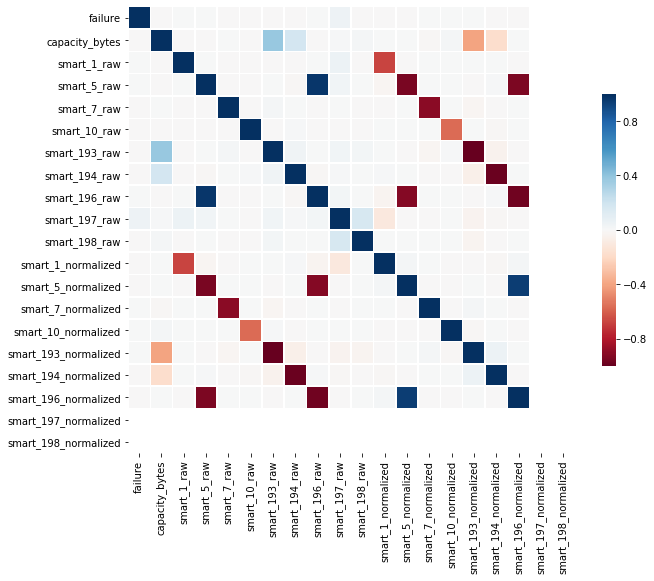

In [130]:
# correlation matrix for hgst drives
hgst_corr_cols = ['failure', 'capacity_bytes'] + list(hgst_nan_ct.index[hgst_nan_ct['percent'] < NAN_PERCENT_THRESHOLD])
hgst_corr = hgst_df[hgst_corr_cols].corr().compute()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(hgst_corr,
            ax=ax,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=.5,
            cmap='RdBu',
            cbar_kws={"shrink": .5})

/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/pandas/core/frame.py:7143: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value enc

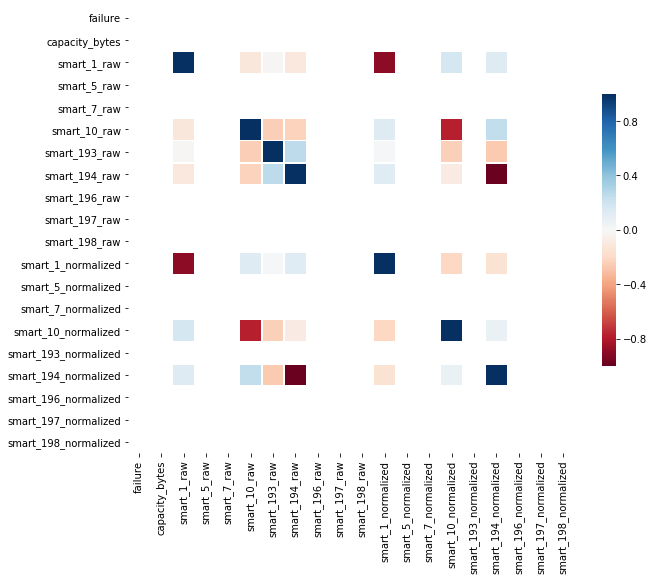

In [131]:
# correlation matrix for hitachi drives
hitachi_corr_cols = ['failure', 'capacity_bytes'] + list(hitachi_nan_ct.index[hitachi_nan_ct['percent'] < NAN_PERCENT_THRESHOLD])
hitachi_corr = hitachi_df[hitachi_corr_cols].corr().compute()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(hitachi_corr,
            ax=ax,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=.5,
            cmap='RdBu',
            cbar_kws={"shrink": .5})

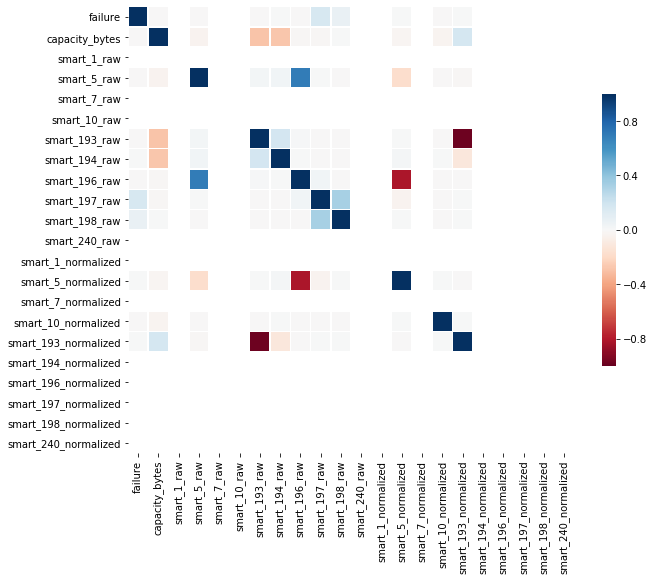

In [132]:
# correlation matrix for toshiba drives
toshiba_corr_cols = ['failure', 'capacity_bytes'] + list(toshiba_nan_ct.index[toshiba_nan_ct['percent'] < NAN_PERCENT_THRESHOLD])
toshiba_corr = toshiba_df[toshiba_corr_cols].corr().compute()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(toshiba_corr,
            ax=ax,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=.5,
            cmap='RdBu',
            cbar_kws={"shrink": .5})

/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


1 / 50. Drive serial number ZJV00AEP
2 / 50. Drive serial number ZCH07GNX
3 / 50. Drive serial number Z304JZJQ
4 / 50. Drive serial number Z3041C62
5 / 50. Drive serial number PL2331LAGSUD2J
6 / 50. Drive serial number ZCH0GBHG
7 / 50. Drive serial number PL1331LAHGEV3H
8 / 50. Drive serial number Z303Y442
9 / 50. Drive serial number ZCH0CDL3
10 / 50. Drive serial number ZA1438NC
11 / 50. Drive serial number ZCH070ZQ
12 / 50. Drive serial number S2ZYJ9GGB00982
13 / 50. Drive serial number ZCH07RVM
14 / 50. Drive serial number ZCH0CE47
15 / 50. Drive serial number ZCH06J4X
16 / 50. Drive serial number Z304KC77
17 / 50. Drive serial number ZCH0CC4V
18 / 50. Drive serial number ZA16RV57
19 / 50. Drive serial number ZCH0657N
20 / 50. Drive serial number ZCH073Z9
21 / 50. Drive serial number S300WDLE
22 / 50. Drive serial number Z3025L0M
23 / 50. Drive serial number ZJV065H9
24 / 50. Drive serial number S2ZYJ9CFC01460
25 / 50. Drive serial number ZCH08BW0
26 / 50. Drive serial number ZCH0CZ

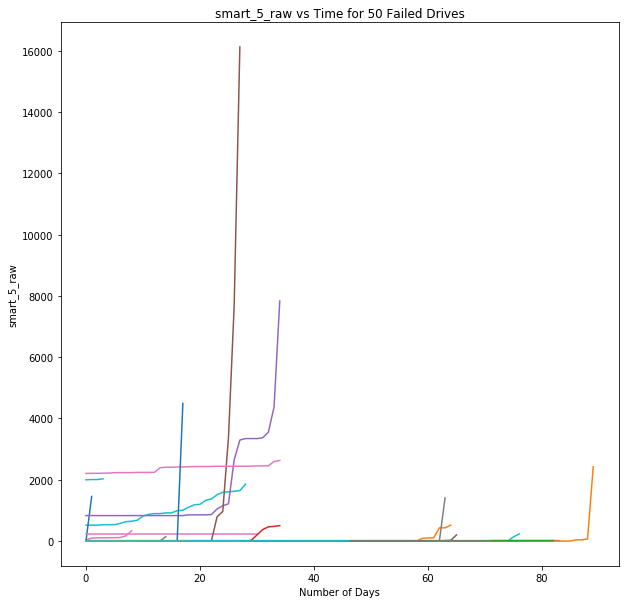

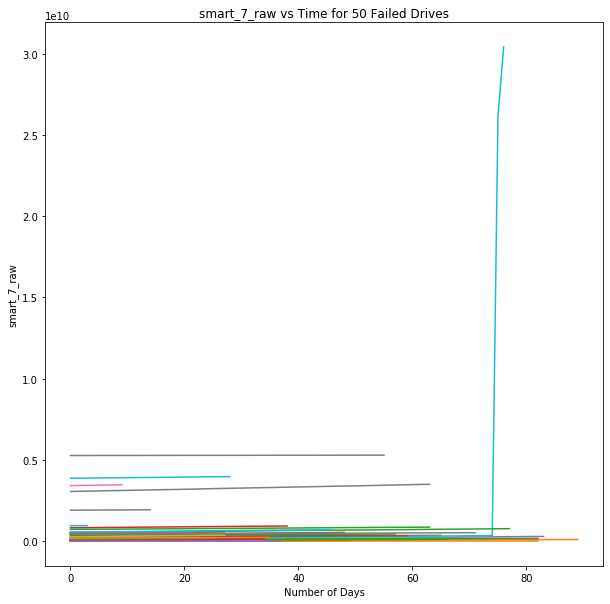

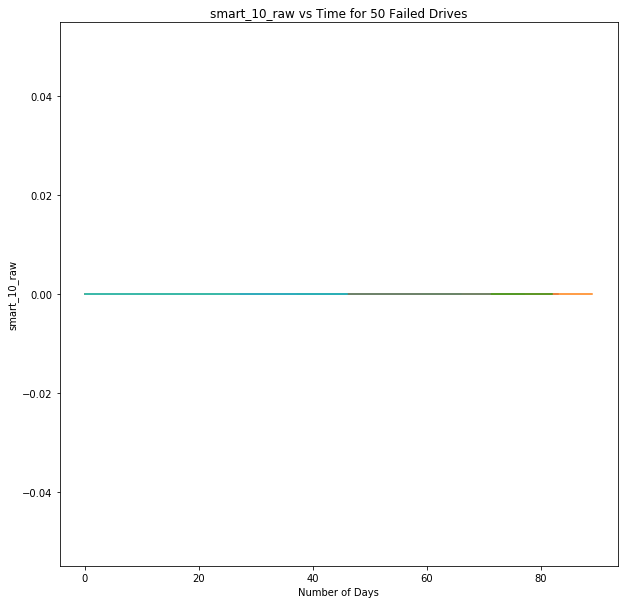

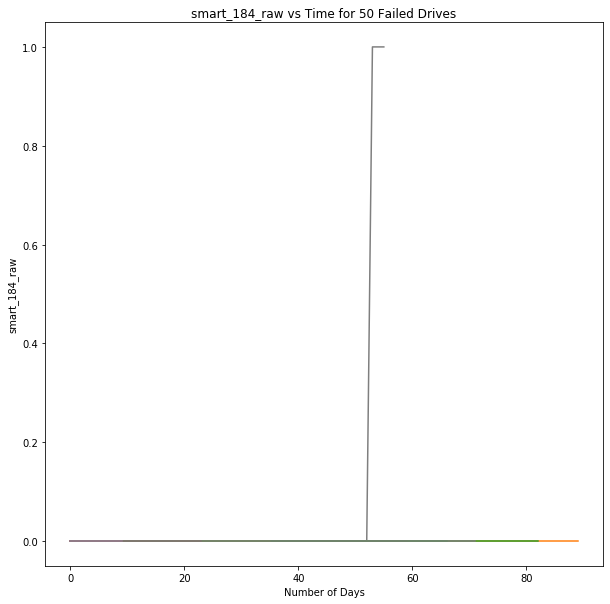

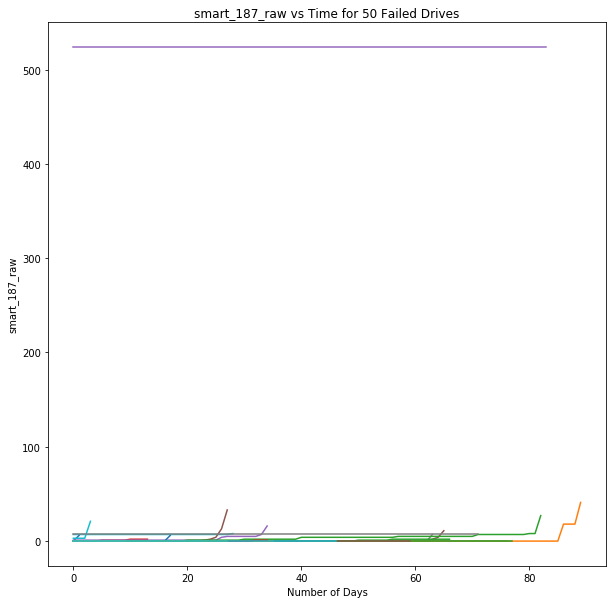

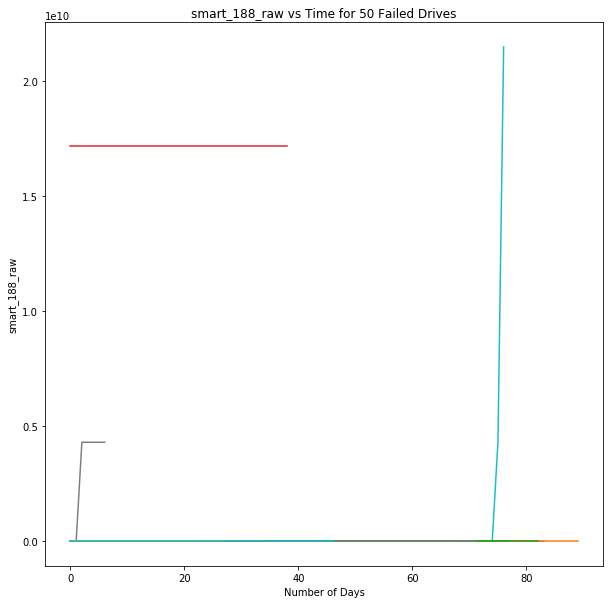

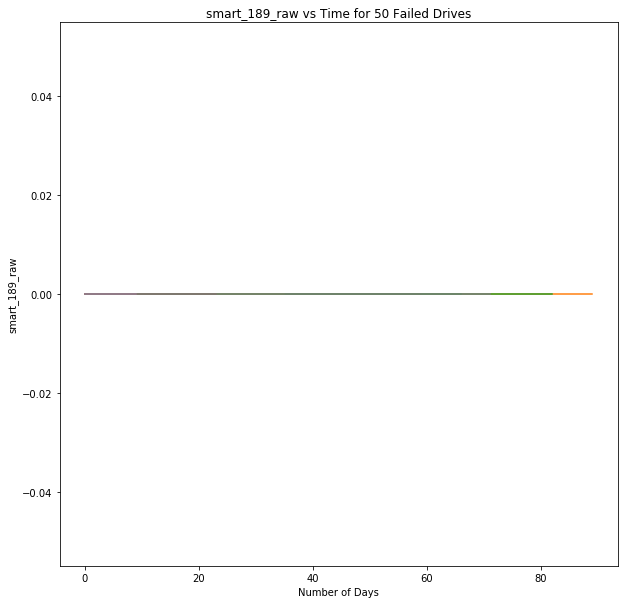

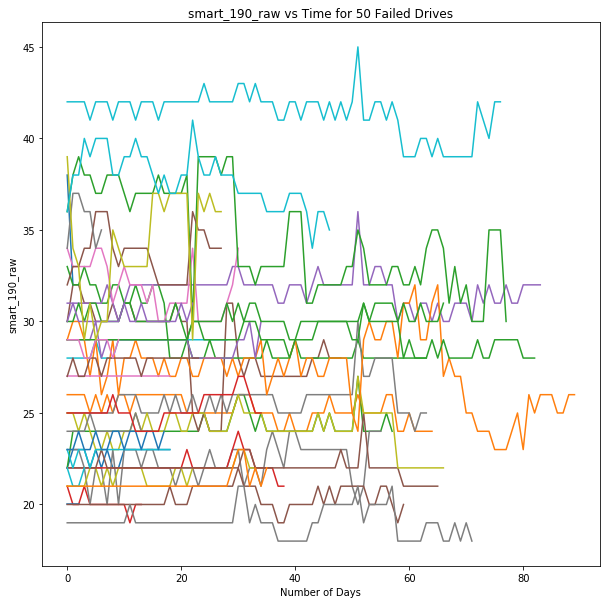

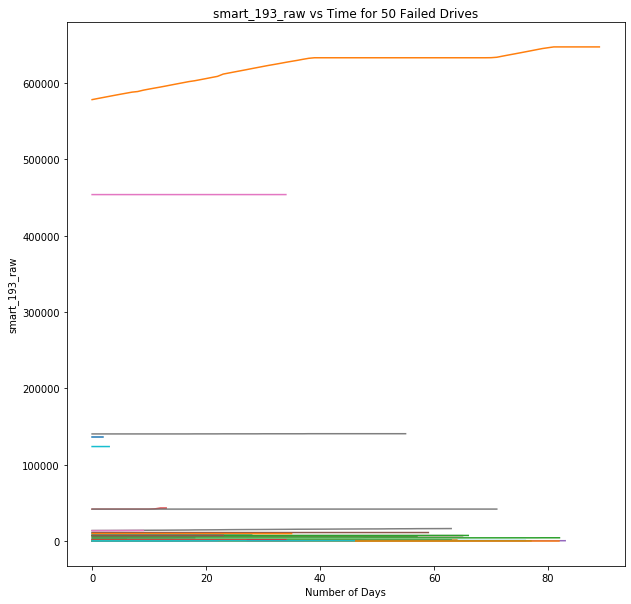

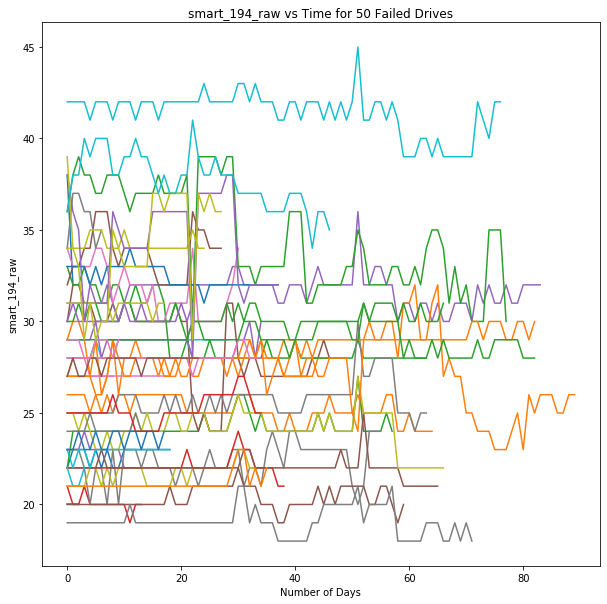

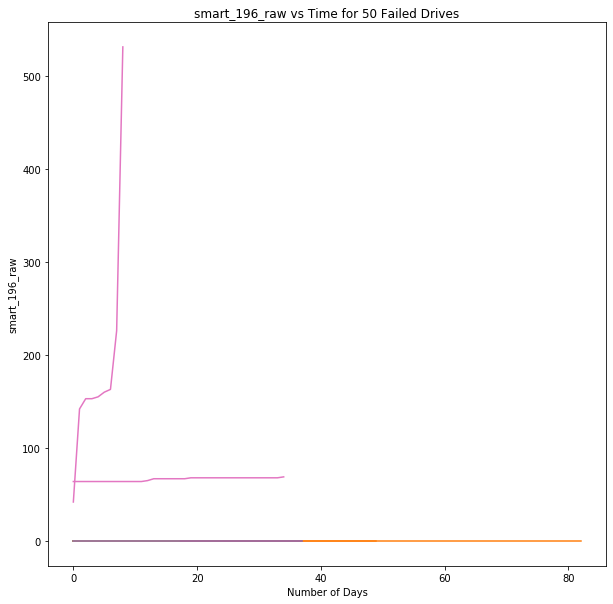

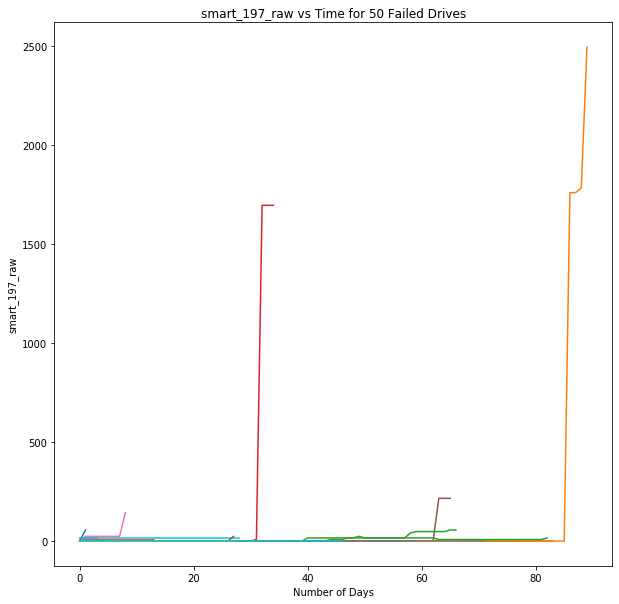

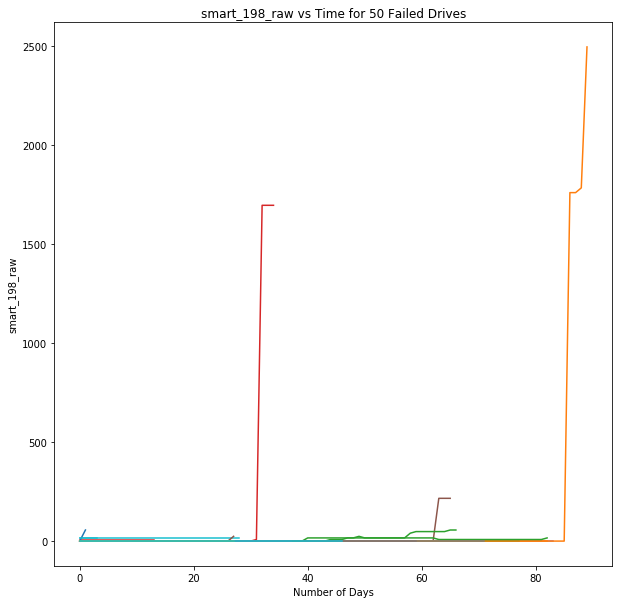

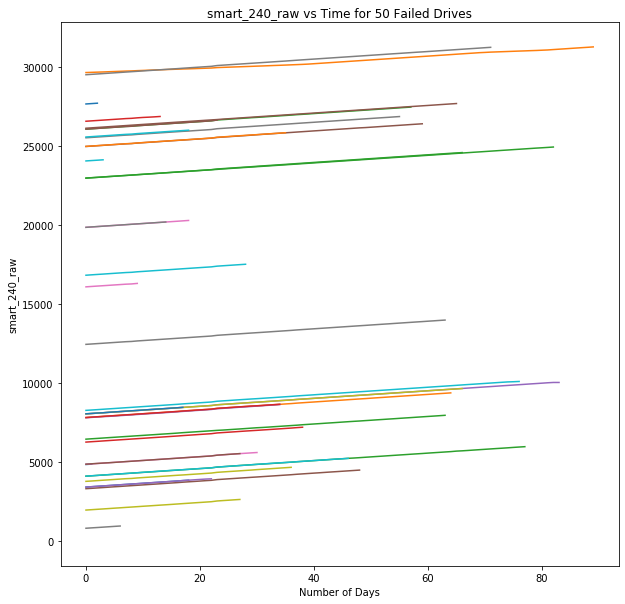

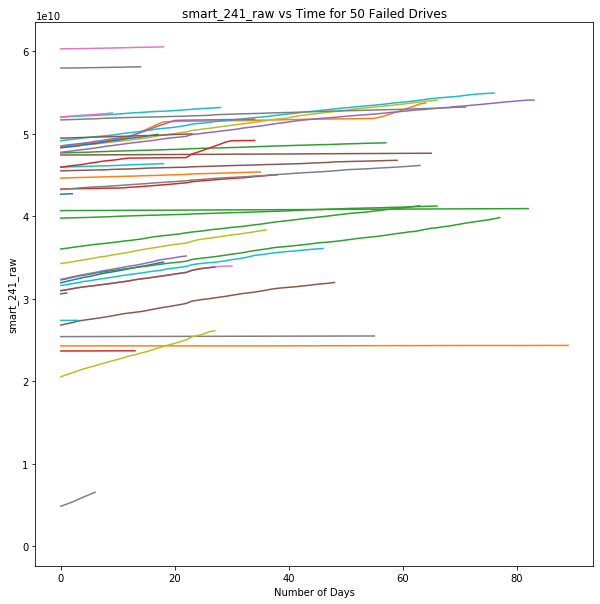

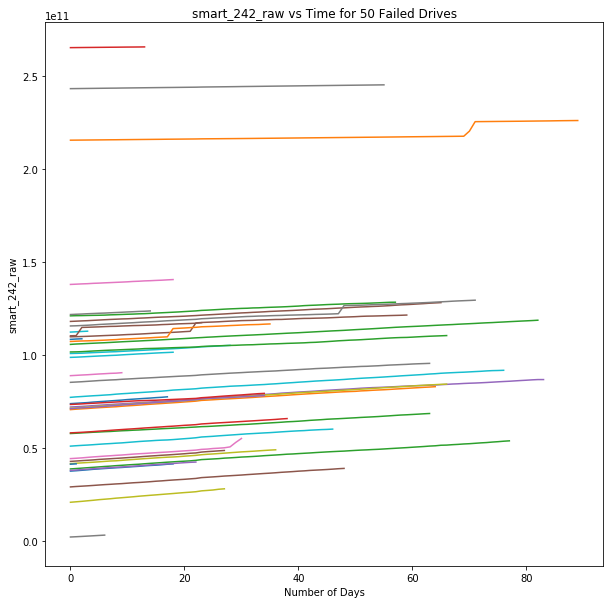

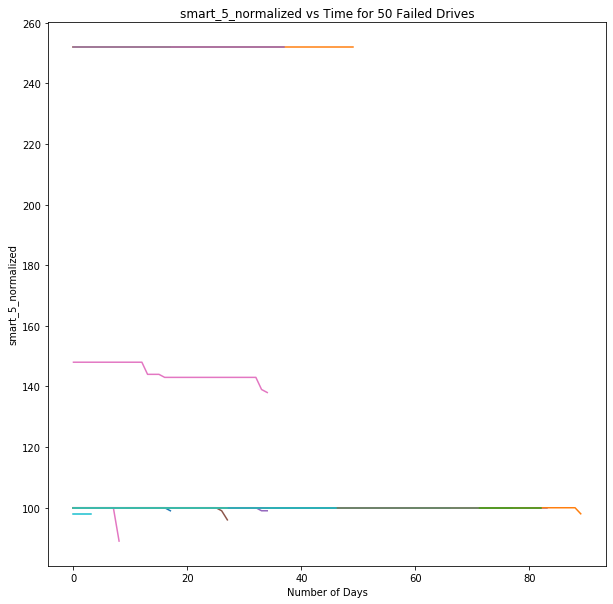

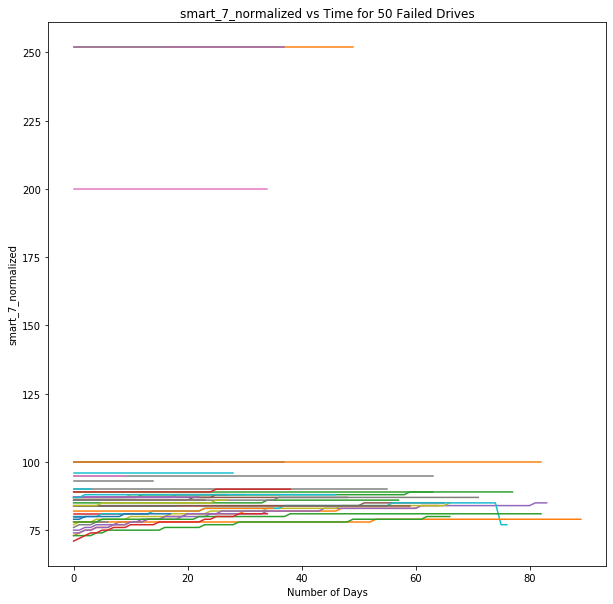

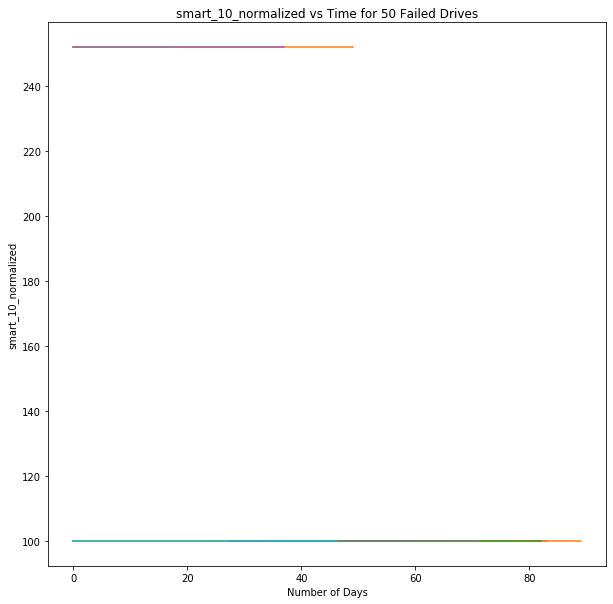

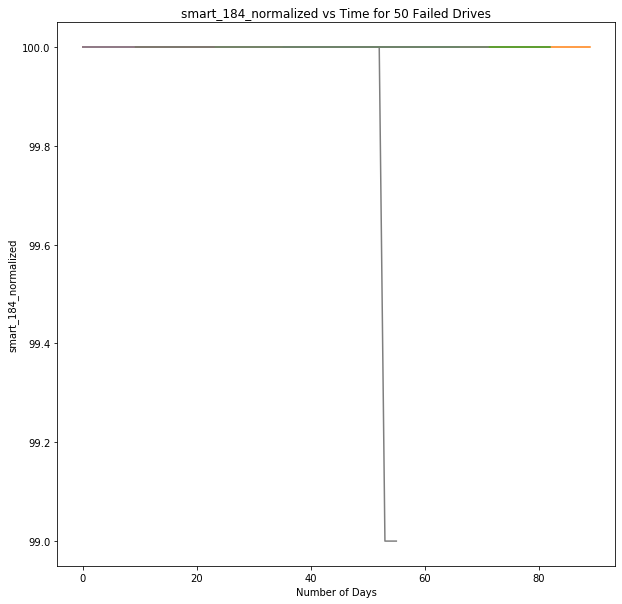

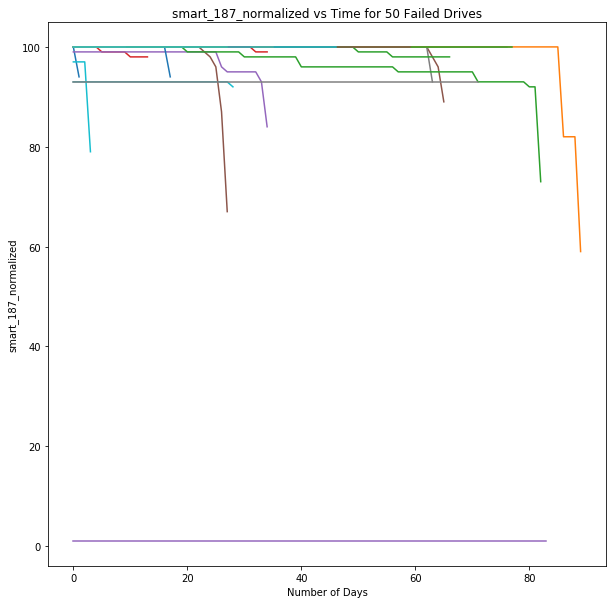

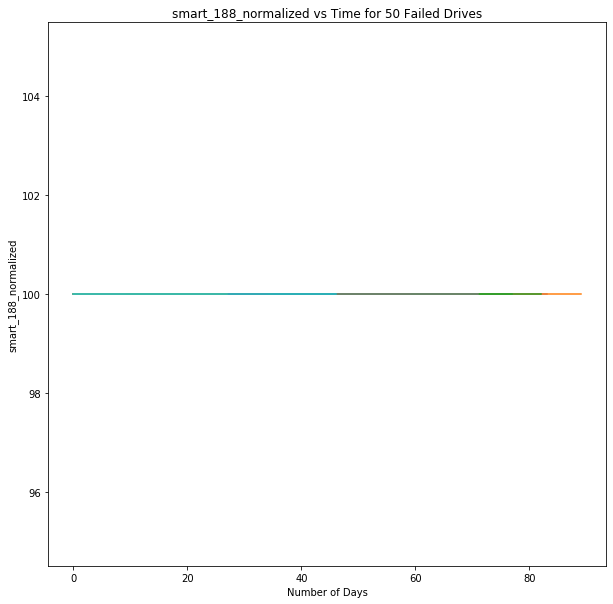

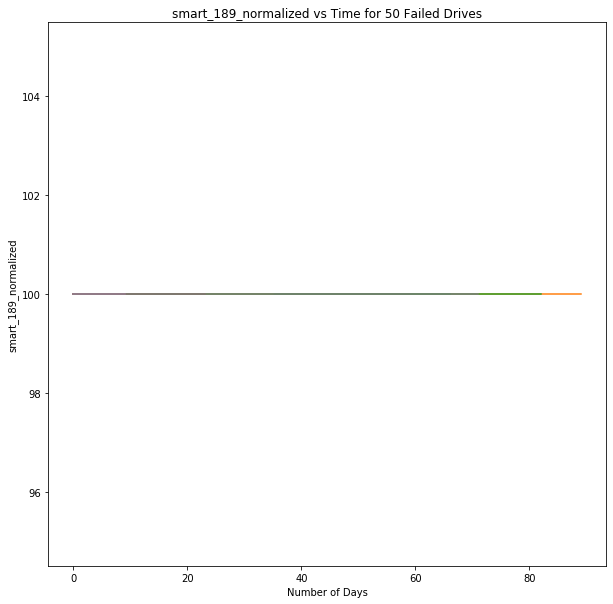

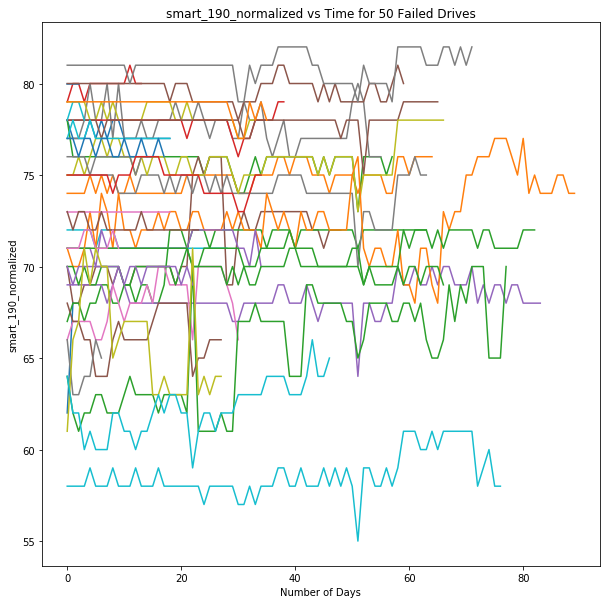

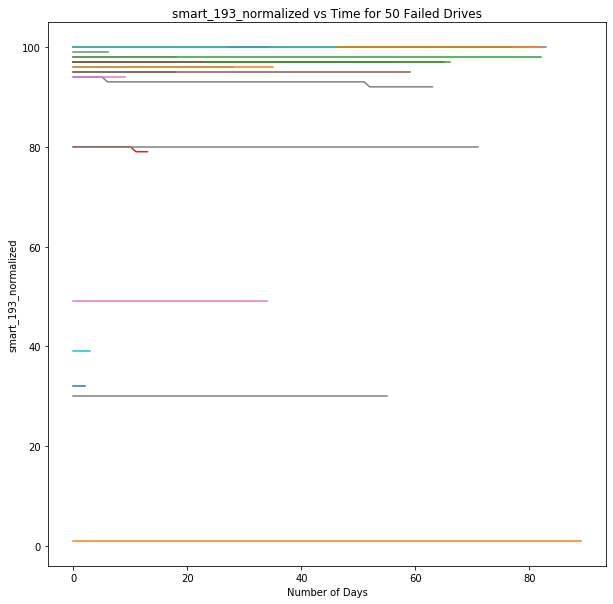

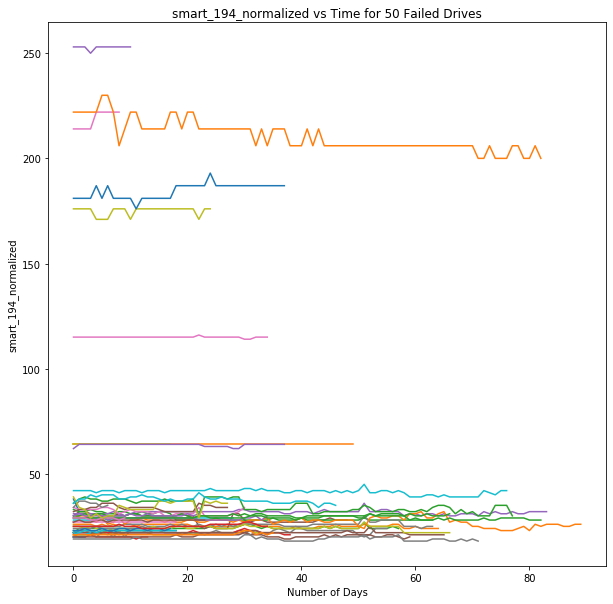

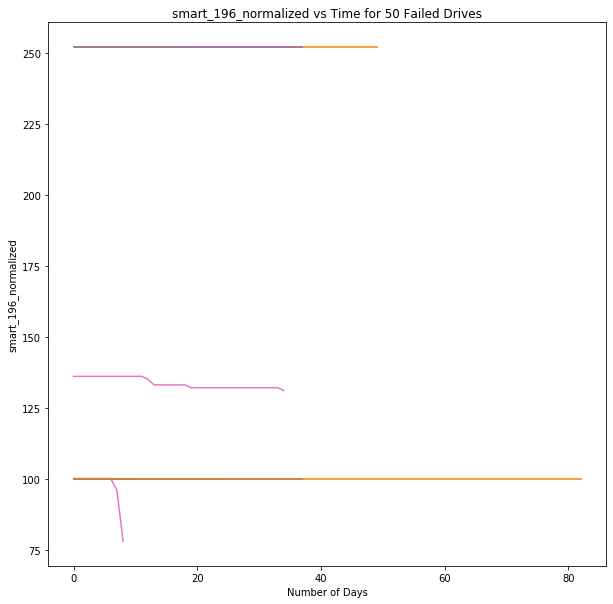

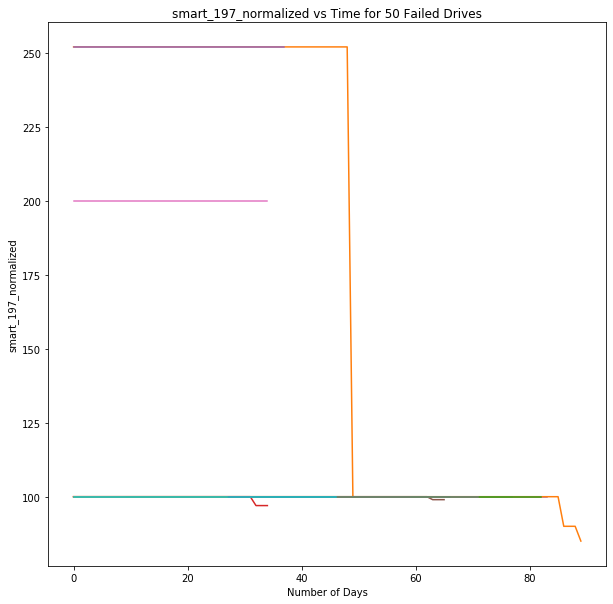

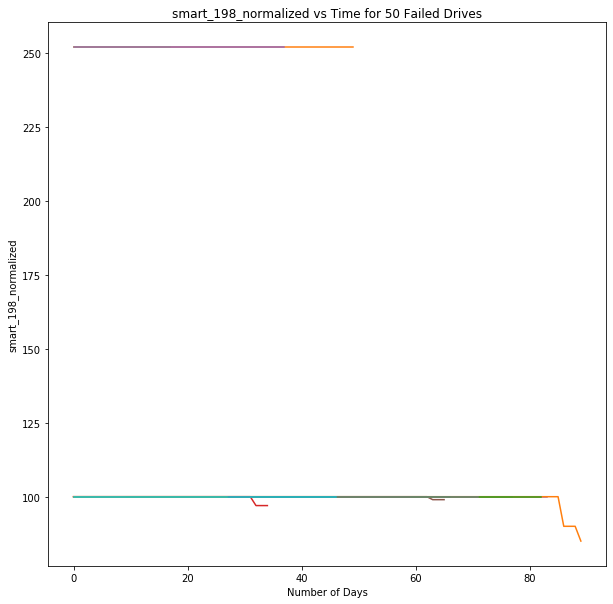

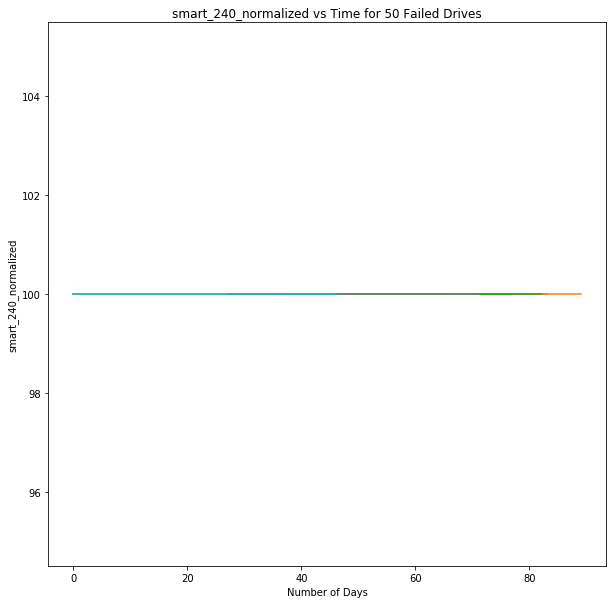

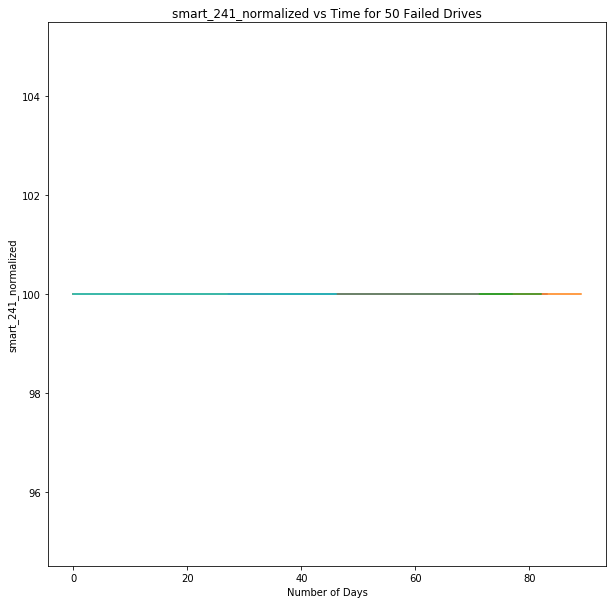

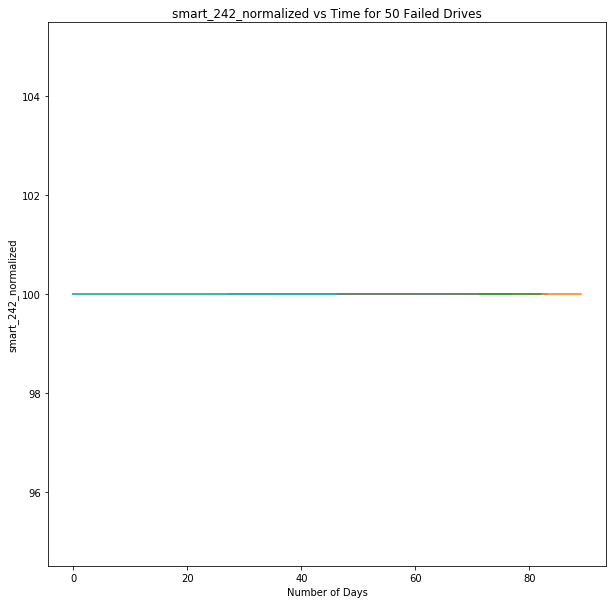

In [88]:
# TODO: Might be better to call compute to get the combined data of all serials in subset
# as opposed to calling it for earch serial number in for loop

# NOTE: running this cell will take a VERY long time (~1hr on intel i7 w/ 16GB ram)
# adjust NUM_DRIVES_TO_SAMPLE to select a small subset to use for plotting
NUM_DRIVES_TO_SAMPLE = 50

# plots for smart stat 5
# cols_to_plot = ['smart_5_raw', 'smart_7_raw']
cols_to_plot = crit_cols_raw + crit_cols_normalized
cols_to_plot.remove('smart_201_raw')            # too many nans
cols_to_plot.remove('smart_201_normalized')     # too many nans

# one figure per smart stat
figs = [plt.figure(i, figsize=(10, 10)) for i in range(len(cols_to_plot))]
axes = [f.add_subplot(111) for f in figs]
for colname, ax in zip(cols_to_plot, axes):
    ax.set_title('{} vs Time for {} Failed Drives'.format(colname, NUM_DRIVES_TO_SAMPLE))
    ax.set_xlabel('Number of Days')
    ax.set_ylabel(colname)
    
# keep track of what hard drives were used to generate the data. NOTE: only the first 16 chars of ser will be saved
failed_ser_subset = np.empty(shape=(NUM_DRIVES_TO_SAMPLE), dtype='<S16')

# make the figures
for i, ser in enumerate(failed_serials['serial_number'].sample(NUM_DRIVES_TO_SAMPLE, random_state=42)):
    # log serial numbers which are being used
    failed_ser_subset[i] = ser
    print('{} / {}. Drive serial number {}'.format(i + 1, NUM_DRIVES_TO_SAMPLE, ser))
    
    # get teh data to make the figures
    drive_data = df[df['serial_number']==ser][cols_to_plot].compute()
    
    # dummy x axis data
    xvals = [i for i in range(drive_data.shape[0])]
    
    # make the plot
    for ax, c in zip(axes, cols_to_plot):
        ax.plot(xvals, drive_data[c])

# save the figures
for f, c in zip(figs, cols_to_plot):
    f.savefig('img/{}_failed.png'.format(c))

# save the serial numbres used in figures
np.save('failed_graphs_serials', failed_ser_subset)

In [89]:
# sample to use for plotting
NUM_DRIVES_TO_SAMPLE = 50

# one figure per smart stat
for colname, ax in zip(cols_to_plot, axes):
    ax.cla()    # clear data from previous plots
    ax.set_title('{} vs Time for {} Working Drives'.format(colname, NUM_DRIVES_TO_SAMPLE))
    ax.set_xlabel('Number of Days')
    ax.set_ylabel(colname)
    
# keep track of what hard drives were used to generate the data. NOTE: only the first 16 chars of ser will be saved
working_ser_subset = np.empty(shape=(NUM_DRIVES_TO_SAMPLE), dtype='<S16')

# make the figures
for i, ser in enumerate(working_serials['serial_number'].sample(NUM_DRIVES_TO_SAMPLE, random_state=42)):
    # log serial numbers which are being used
    working_ser_subset[i] = ser
    print('{} / {}. Drive serial number {}'.format(i + 1, NUM_DRIVES_TO_SAMPLE, ser))
    
    # get teh data to make the figures
    drive_data = df[df['serial_number']==ser][cols_to_plot].compute()
    
    # dummy x axis data
    xvals = [i for i in range(drive_data.shape[0])]
    
    # make the plot
    for ax, c in zip(axes, cols_to_plot):
        ax.plot(xvals, drive_data[c])

# save the figures
for f, c in zip(figs, cols_to_plot):
    f.savefig('img/{}_working.png'.format(c))

# save the serial numbres used in figures
np.save('working_graphs_serials', working_ser_subset)

1 / 50. Drive serial number ZCH08971
2 / 50. Drive serial number ZA12SVHG
3 / 50. Drive serial number PL1331LAHD1H5H
4 / 50. Drive serial number Z302BTGB
5 / 50. Drive serial number ZJV0WEN9
6 / 50. Drive serial number X7ERT51ST
7 / 50. Drive serial number ZJV0WESK
8 / 50. Drive serial number PL1331LAHE0WGH
9 / 50. Drive serial number Z302SN7X
10 / 50. Drive serial number Z304HSFB
11 / 50. Drive serial number ZJV00GEL
12 / 50. Drive serial number 4589K0VGFMYB
13 / 50. Drive serial number ZA189HVZ
14 / 50. Drive serial number ZA181LGQ
15 / 50. Drive serial number ZA129HH8
16 / 50. Drive serial number ZCH07DLG
17 / 50. Drive serial number Z30597RQ
18 / 50. Drive serial number Z305GVTQ
19 / 50. Drive serial number ZA13ZRZL
20 / 50. Drive serial number ZCH0CJCG
21 / 50. Drive serial number ZJV1373P
22 / 50. Drive serial number ZA149PP3
23 / 50. Drive serial number PL2331LAHDWDTJ
24 / 50. Drive serial number ZJV007BD
25 / 50. Drive serial number Z3059P4N
26 / 50. Drive serial number ZA1855A

In [ ]:
plt.close('all')

### Backblaze's analysis:

Backblaze also performed some analysis on the SMART stats 5, 187, 188, 197, 198. They concluded that just having one of the stats in an abnormal state may not necessarily mean anything, but all of them being abnormal at the same time is a red flag. Details and some nice diagrams can be found here: https://www.backblaze.com/blog/what-smart-stats-indicate-hard-drive-failures/

## Visualize Embeddings

In [69]:
from dask.distributed import Client
# from sklearn.externals.joblib import parallel_backend

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import seaborn as sns

In [47]:
# get the groupby object. there should be one gourp per serial nunmbers
# get only those columns which have less than 50 percent nan values
grouped_data_cols = ['serial_number', 'model', 'capacity_bytes'] + list(nan_count.index[nan_count['percent'] < 50])
groups = df[grouped_data_cols].groupby('serial_number')

In [25]:
# get simple stats to represent time series of each hard drive
group_means = groups.mean().compute().add_prefix('mean_')
group_stds = groups.std().compute().add_prefix('std_')
group_days = groups.size().compute().to_frame('days')
group_days.index.name = None    # to match the other agg results, so that it can be concatenated easily

In [55]:
# put the stats together into one df
group_stats = pd.concat([group_means, group_stds, group_days], axis=1)

# make serial number a column instead of index. will be easier for calc later
group_stats = group_stats.reset_index()

# need to add failed label
group_stats['failure'] = group_stats['serial_number'].isin(failed_serials['serial_number'])

In [56]:
group_stats.head()

,serial_number,mean_capacity_bytes,mean_smart_1_raw,mean_smart_5_raw,mean_smart_7_raw,mean_smart_10_raw,mean_smart_187_raw,mean_smart_188_raw,mean_smart_190_raw,mean_smart_193_raw,...,std_smart_190_normalized,std_smart_193_normalized,std_smart_194_normalized,std_smart_197_normalized,std_smart_198_normalized,std_smart_240_normalized,std_smart_241_normalized,std_smart_242_normalized,days,failure
0,175PP3HDT,5.001079e+11,0.0,0.0,0.0,0.0,NaN,NaN,NaN,991.0,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,92,False
1,175PP3I4T,5.001079e+11,0.0,0.0,0.0,0.0,NaN,NaN,NaN,2179.0,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,92,False
2,175PP3I5T,5.001079e+11,0.0,0.0,0.0,0.0,NaN,NaN,NaN,2025.0,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,92,False
3,175PP3I6T,5.001079e+11,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1861.0,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,92,False
4,175PP3I7T,5.001079e+11,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1074.0,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,55,True


In [61]:
# FIXME: find a smarter way to deal with nans. drop columns not rows
# for now, just drop it. this drops ~25k observations and leaves us with ~83k
clean_group_stats = group_stats.dropna(how='any')

# make sure we still have enough failure drive data
print(clean_group_stats['failure'].sum(), 'failed drives data retained')

clean_group_stats[clean_group_stats['failure']].head()

312 failed drives data retained


,serial_number,mean_capacity_bytes,mean_smart_1_raw,mean_smart_5_raw,mean_smart_7_raw,mean_smart_10_raw,mean_smart_187_raw,mean_smart_188_raw,mean_smart_190_raw,mean_smart_193_raw,...,std_smart_190_normalized,std_smart_193_normalized,std_smart_194_normalized,std_smart_197_normalized,std_smart_198_normalized,std_smart_240_normalized,std_smart_241_normalized,std_smart_242_normalized,days,failure
21325,S300VL9M,4.000787e+12,1.027606e+08,0.0,4.507774e+08,0.0,0.000000,0.0,24.168539,37762.629213,...,1.068516,0.0,1.068516,0.0,0.0,0.0,0.0,0.0,89,True
22115,S300XE7T,4.000787e+12,1.281739e+08,0.0,3.912721e+08,0.0,0.000000,0.0,25.666667,36090.966667,...,0.479463,0.0,0.479463,0.0,0.0,0.0,0.0,0.0,30,True
22855,S300Z3QA,4.000787e+12,9.608502e+07,0.0,2.551536e+08,0.0,11.000000,0.0,22.000000,167936.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2,True
22904,S300Z3XP,4.000787e+12,1.308649e+08,0.0,2.954825e+08,0.0,9.500000,0.0,21.000000,20570.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,8,True
23631,S300Z61D,4.000787e+12,1.334681e+08,0.0,2.539329e+11,0.0,13.266667,1.0,17.100000,38451.222222,...,1.091849,0.0,1.091849,0.0,0.0,0.0,0.0,0.0,90,True


**NOTE** The percentage of failed hard drives retained is 312/393 = 0.79, and the percentage of healthy hard drives retained is 0.77. So in terms of NaN values dropped in the call in previous cell, the distribution is evenly spread across failed and healthy. (proportion of NaN is same)

In [64]:
# scale the data and find the top principal components
scaler = StandardScaler()
pca = PCA(n_components=3, random_state=42, whiten=True)\
        .fit_transform(scaler.fit_transform(clean_group_stats.drop(['serial_number', 'failure'], axis=1)))

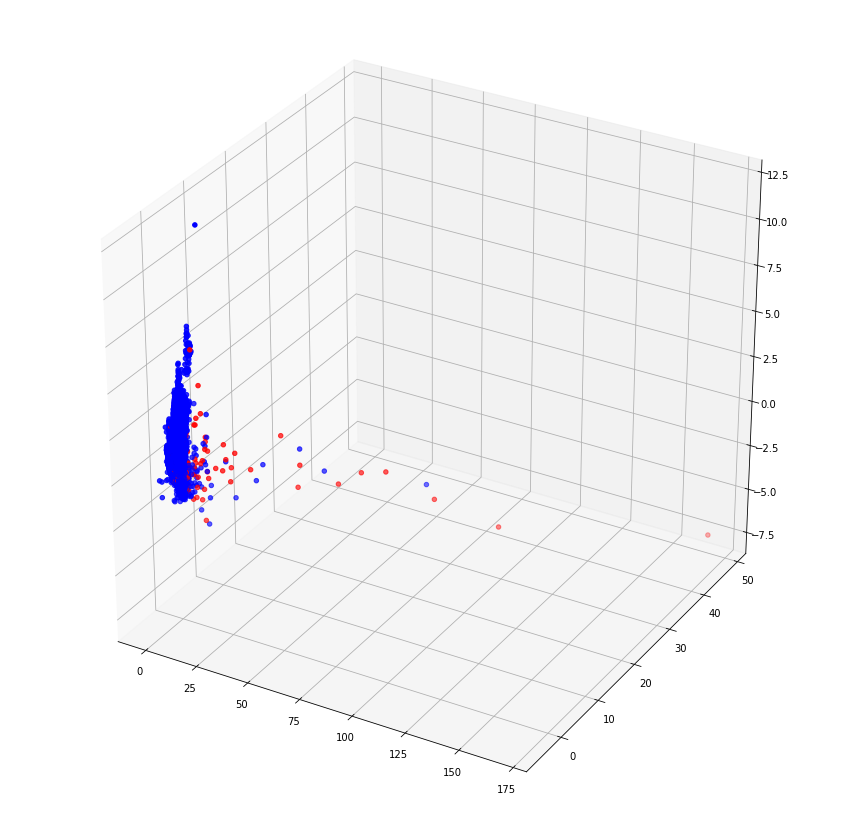

In [70]:
# plot pca
colors = ['blue', 'red']
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca[:, 0],
           pca[:, 1],
           pca[:, 2],
           c=clean_group_stats['failure'],
           cmap=matplotlib.colors.ListedColormap(colors))

In [8]:
# tsne embeddings may be more meaningful than pca, but it is extremely slow
# tsne = TSNE(n_components=3, random_state=42)\
#         .fit_transform(scaler.fit_transform(clean_group_stats.drop(['serial_number', 'failure'], axis=1)))